In [126]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import os

from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.model_selection import train_test_split

In [100]:
df = pd.read_csv("./diabetes.csv")

In [101]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [102]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [103]:
df.corr("pearson")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [104]:
cor_data = df.corr("pearson").stack().reset_index().rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'})


base = alt.Chart(cor_data).encode(
    x='variable2:O',
    y='variable:O'    
)

text = base.mark_text().encode(
    text='correlation_label',
    color=alt.condition(
        alt.datum.correlation > 0.5, 
        alt.value('white'),
        alt.value('black')
    )
)

cor_plot = base.mark_rect().encode(
    color='correlation:Q'
)

cor_plot

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [105]:
df['Glucose'] = df['Glucose'].replace(0, df['Glucose'].mean())
# Correcting missing values in blood pressure
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].mean()) # There are 35 records with 0 BloodPressure in dataset
# Correcting missing values in BMI
df['BMI'] = df['BMI'].replace(0, df['BMI'].median())
# Correct missing values in Insulin and SkinThickness

df['SkinThickness'] = df['SkinThickness'].replace(0, df['SkinThickness'].median())
df['Insulin'] = df['Insulin'].replace(0, df['Insulin'].median())

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [504]:
diabetes_women = pd.DataFrame({
    'pregnancies': df["Pregnancies"][df["Outcome"] == 1].value_counts().to_frame().index.to_list(),
    'frequency': df["Pregnancies"][df["Outcome"] == 1].value_counts().values,
    'name': "diabetes"
})

non_diabetes_women = pd.DataFrame({
    'pregnancies': df["Pregnancies"][df["Outcome"] == 0].value_counts().to_frame().index.to_list(),
    'frequency': df["Pregnancies"][df["Outcome"] == 0].value_counts().values,
    'name': "non diabetes"
})

area1 = alt.Chart(diabetes_women).mark_area(
    interpolate='monotone'
).encode(
    alt.X("pregnancies", title="Pregnancies quantity"),
    alt.Y("frequency", title='Number of women'),
    opacity=alt.value(0.6),
    color="name"
)

area2 = alt.Chart(non_diabetes_women).mark_area(
    interpolate='monotone'
).encode(
    alt.X("pregnancies", scale=alt.Scale(zero=False, nice=False), title="Pregnancies quantity"),
    alt.Y("frequency", title='Number of women'),
    opacity=alt.value(0.6),
    color="name"
)

area1 + area2

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

In [663]:
source = pd.DataFrame({
    'a': ['diabetes', 'non-diabetes'],
    'b': [df[df["Outcome"] == 1]["Outcome"].count(), df[df["Outcome"] == 0]["Outcome"].count()]
})

alt.Chart(source).mark_bar().encode(
    alt.X("a", title=""),
    alt.Y("b", title='Number of people in sample'),
).properties(
    width=200,
    height=300)


alt.Chart(...)

In [675]:
# alt.Chart(df).mark_bar().encode(
#     alt.X("Outcome"),
#     alt.Y("Glucose"),
#     color='Outcome:N',
# ).properties(
#     width=200,
#     height=300)


alt.Chart(df).transform_density(
    'Glucose',
    as_=['Glucose', 'density'],
    # extent=[5, 50],
    groupby=['Outcome']
).mark_area(orient='horizontal').encode(
    y='Glucose:Q',
    color='Outcome:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    column=alt.Column(
        'Outcome:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=100
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

alt.Chart(...)

In [655]:
# Data Transformation
q  = QuantileTransformer()
X = q.fit_transform(df)
transformedDF = q.transform(X)
transformedDF = pd.DataFrame(X)
transformedDF.columns =['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

transformedDF.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2623: UserWarning: n_quantiles (1000) is greater than the total number of samples (768). n_quantiles is set to n_samples.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.747718,0.810300,0.516949,0.801825,0.256193,0.591265,0.750978,0.889831,1.0
1,0.232725,0.091265,0.290091,0.644720,0.256193,0.213168,0.475880,0.558670,0.0
2,0.863755,0.956975,0.233377,0.357888,0.256193,0.077575,0.782269,0.585398,1.0
3,0.232725,0.124511,0.290091,0.357888,0.662973,0.284224,0.106258,0.000000,0.0
4,0.000000,0.721643,0.005215,0.801825,0.834420,0.926988,0.997392,0.606258,1.0


In [656]:
features = transformedDF.drop(["Outcome"], axis=1)
labels = transformedDF["Outcome"]
# train (70%) and test (30%)
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
print (f'Shape of Train Data : {x_train.shape}')
print (f'Shape of Test Data : {x_test.shape}')

Shape of Train Data : (537, 8)
Shape of Test Data : (231, 8)


Validation data will be also useful to provide an unbiased **evaluation of a model** fit on the **training dataset** while tuning model hyperparameters. Model occasionally sees this data, but never does it *Learn* from this. Validation set is also called dev set.

![image.png](./dataset.jpeg)

In [657]:
x_dev, x_dev_test, y_dev, y_dev_test = train_test_split(x_test, y_test, test_size=0.5, random_state=2)

print (f'Shape of Dev/Validation Data : {x_dev.shape}')

Shape of Dev/Validation Data : (115, 8)


Ok so we've prepared train, test and validation data. The next question is how many hidden layers and neurons should we use? This is common question and also if we google internet in appropriative way ... this is imposible to have only one answear. In **Introduction to Neural Networks for Java**, Second Edition by *jeffheaton* we've found defnition: 

![image.png](./quantityOfHiddenLayers.jpeg)

Base on our case two of hidden layers will be good choice. Rhere is still an issue how many neurons per layer should we use. 
1. For the first input layer should be 8 neurons because we have 8 features/columns.
2. Output layer should contain 1 neuron because our result is 1 or 0 (diabetic or not).

Using too few neurons in the hidden layers will result in something called underfitting. Underfitting occurs when there are too few neurons in the hidden layers to adequately detect the signals in a complicated data set.

Using too many neurons in the hidden layers can result in several problems. First, too many neurons in the hidden layers may result in overfitting. Overfitting occurs when the neural network has so much information processing capacity that the limited amount of information contained in the training set is not enough to train all of the neurons in the hidden layers.


We decided to use this formula:
$$N_h = \frac{N_s}{a*(N_i+N_o)}$$

𝑁𝑖 = number of input neurons.</br>
𝑁𝑜 = number of output neurons.</br>
𝑁𝑠 = number of samples in training data set.</br>
a = an arbitrary scaling factor usually 2-10.</br>


Also with formula above we wanted to follow rules: 

- The number of hidden neurons should be between the size of the input layer and the size of the output layer. <1;8>
- The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer. 8*2/3+1 = 6.(3)
- The number of hidden neurons should be less than twice the size of the input layer. x < 2*8 => x < 16


So we decided: 

$$N_{h1} = \frac{537}{5*(8+1)} = ~12$$

$$N_{h1} = \frac{537}{10*(8+1)} = ~6$$

![image.png](./network.png)

In [658]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

inputs = Input(name='inputs', shape=[x_train.shape[1],])
layer = Dense(12, name='FC1')(inputs)
layer = BatchNormalization(name='BC1')(layer)
layer = Activation('relu', name='Activation1')(layer)
layer = Dropout(0.3, name='Dropout1')(layer)
layer = Dense(6, name='FC2')(layer)
layer = BatchNormalization(name='BC2')(layer)
layer = Activation('relu', name='Activation2')(layer)
layer = Dropout(0.3, name='Dropout2')(layer)
layer = Dense(1, name='OutLayer')(layer)
layer = Activation('sigmoid', name='sigmoid')(layer)
model = Model(inputs=inputs, outputs=layer)

model.summary()


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 8)]               0         
                                                                 
 FC1 (Dense)                 (None, 12)                108       
                                                                 
 BC1 (BatchNormalization)    (None, 12)                48        
                                                                 
 Activation1 (Activation)    (None, 12)                0         
                                                                 
 Dropout1 (Dropout)          (None, 12)                0         
                                                                 
 FC2 (Dense)                 (None, 6)                 78        
                                                                 
 BC2 (BatchNormalization)    (None, 6)                 24 

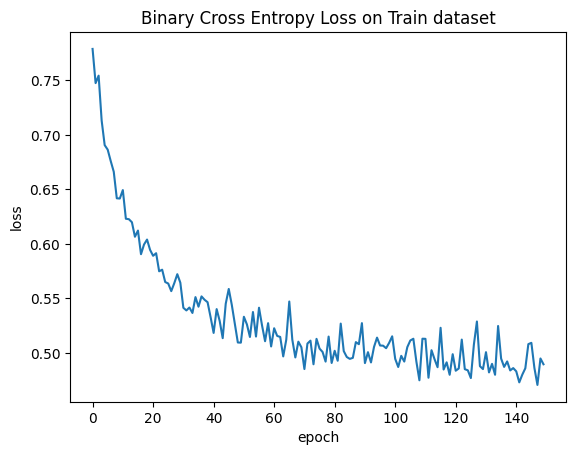

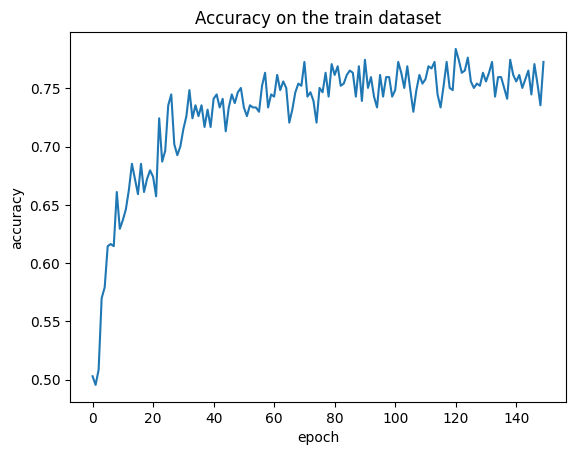

In [659]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
historic = model.fit(x=x_train, y=y_train, epochs=150, verbose=0)

# Plotting loss
plt.plot(historic.history['loss'])
plt.title('Binary Cross Entropy Loss on Train dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plotting accuracy metric
plt.plot(historic.history['accuracy'])
plt.title('Accuracy on the train dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [660]:
# Train accuracy

y_train_prediction = model.predict(x_train)

y_train_prediction = np.around(y_train_prediction)

y_train_prediction = np.asarray(y_train_prediction)

print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y_train, y_train_prediction), 
                                                                  classification_report(y_train, y_train_prediction)))

17/17 [==============================] - 0s 2ms/step
	Accuracy:0.790
	Classification Report
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85       353
         1.0       0.74      0.59      0.66       184

    accuracy                           0.79       537
   macro avg       0.78      0.74      0.75       537
weighted avg       0.79      0.79      0.78       537



In [661]:
# Test accuracy

y_test_prediction = model.predict(x_test)

y_test_prediction = np.around(y_test_prediction)

y_test_prediction = np.asarray(y_test_prediction).tolist()

print('\tAccuracy:{:0.3f}\n\tClassification Report\n{}'.format(accuracy_score(y_test, y_test_prediction), 
                                                                  classification_report(y_test, y_test_prediction)))

scores = model.evaluate(x_test, y_test)
print (f'{model.metrics_names[1]} : {round(scores[1]*100, 2)} %')

8/8 [==============================] - 0s 2ms/step
	Accuracy:0.762
	Classification Report
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82       147
         1.0       0.70      0.60      0.65        84

    accuracy                           0.76       231
   macro avg       0.75      0.73      0.73       231
weighted avg       0.76      0.76      0.76       231

8/8 [==============================] - 0s 3ms/step - loss: 0.4802 - accuracy: 0.7619
accuracy : 76.19 %


In [662]:
dataResult1 = pd.DataFrame({
    'result':y_test, 
    'name': "y_test",
    'item_number': [i for i,x in enumerate(y_test)]
    })


dataResult2 = pd.DataFrame({
    'result':[x[0] for x in y_test_prediction],
    'name': "y_test_prediction",
    'item_number': [i for i,x in enumerate(y_test)]
    })

chart1 = alt.Chart(dataResult1).mark_area(
    interpolate='monotone'
).encode(
    x = alt.X('item_number'),
    y = alt.Y('result', scale=alt.Scale(domain=[-1, 2])),
    color='name'
)

chart2 = alt.Chart(dataResult2).mark_area(
    interpolate='monotone'
).encode(
    x = alt.X('item_number'),
    y = alt.Y('result', scale=alt.Scale(domain=[-1, 2])),
    opacity=alt.value(0.6),
    color='name'
)

chart1 + chart2

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)